Set up connection between Colab & GG Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data visualize

In [35]:
import tensorflow as tf

BATCH_SIZE = 32
IMAGE_SIZE = (128,128)

train_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Data/egg-split-cropped/train",
    label_mode = "binary",
    color_mode = "rgb",
    seed = 42,
    image_size = IMAGE_SIZE,
    batch_size = None,
    shuffle = True
)

normal_set = train_set.filter(lambda x, y: tf.squeeze(tf.equal(y, 1)))
broken_set = train_set.filter(lambda x, y: tf.squeeze(tf.equal(y, 0)))
normal_set = normal_set.repeat(4)

balanced_train = normal_set.concatenate(broken_set)
balanced_train = balanced_train.shuffle(2000).batch(BATCH_SIZE)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Data/egg-split-cropped/test",
    label_mode = "binary",
    color_mode = "rgb",
    seed = 42,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False
)

val_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Data/egg-split-cropped/val",
    label_mode = "binary",
    color_mode = "rgb",
    seed = 42,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False
)

class_names = train_set.class_names
print("Class names:", class_names)

for x, y in balanced_train.take(1):
    print(x.shape)

Found 599 files belonging to 2 classes.
Found 130 files belonging to 2 classes.
Found 129 files belonging to 2 classes.
Class names: ['Damaged', 'Not Damaged']
(32, 128, 128, 3)


Build Model CNN

In [43]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(factor=0.1),
])

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history = model.fit(
    balanced_train,
    validation_data=val_set,
    epochs=15
  )

Epoch 1/15
     29/Unknown 45s 1s/step - accuracy: 0.5171 - loss: 1.1304 - precision_7: 0.5144 - recall_7: 0.5792

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


29/29 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.5176 - loss: 1.1222 - precision_7: 0.5139 - recall_7: 0.5758 - val_accuracy: 0.7907 - val_loss: 0.6083 - val_precision_7: 0.3077 - val_recall_7: 0.1818
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5773 - loss: 0.6636 - precision_7: 0.5664 - recall_7: 0.4652 - val_accuracy: 0.7984 - val_loss: 0.5863 - val_precision_7: 0.4167 - val_recall_7: 0.4545
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6951 - loss: 0.5840 - precision_7: 0.7631 - recall_7: 0.4973 - val_accuracy: 0.6047 - val_loss: 0.7463 - val_precision_7: 0.2364 - val_recall_7: 0.5909
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6315 - loss: 0.6326 - precision_7: 0.6360 - recall_7: 0.5326 - val_accuracy: 0.2713 - val_loss: 0.8196 - val_precision_7: 0.1897 - val_recall_7: 1.0000
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6407 - loss: 0.6281 - precision_7: 0.6264 - recall_7: 0.6702 - val_accuracy: 0.7752

In [52]:
from sklearn.metrics import classification_report
# --- 4. Function đánh giá dataset với classification_report ---
def evaluate_report(dataset, dataset_name="Dataset"):
    y_true = []
    y_pred = []

    for x, y in dataset:
        preds = model.predict(x, verbose=0)
        preds = (preds > 0.5).astype(int)
        y_true.extend(y.numpy())
        y_pred.extend(preds.flatten())

    print(f"\nClassification Report for {dataset_name}:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# --- 5. In kết quả ---
evaluate_report(balanced_train, "Train")
evaluate_report(val_set, "Validation")
evaluate_report(test_set, "Test")


Classification Report for Train:
              precision    recall  f1-score   support

     Damaged     0.9707    0.8122    0.8844       490
 Not Damaged     0.8217    0.9725    0.8908       436

    accuracy                         0.8877       926
   macro avg     0.8962    0.8924    0.8876       926
weighted avg     0.9006    0.8877    0.8874       926


Classification Report for Validation:
              precision    recall  f1-score   support

     Damaged     0.9647    0.7664    0.8542       107
 Not Damaged     0.4318    0.8636    0.5758        22

    accuracy                         0.7829       129
   macro avg     0.6983    0.8150    0.7150       129
weighted avg     0.8738    0.7829    0.8067       129


Classification Report for Test:
              precision    recall  f1-score   support

     Damaged     0.9759    0.7570    0.8526       107
 Not Damaged     0.4468    0.9130    0.6000        23

    accuracy                         0.7846       130
   macro avg     0.711

In [47]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_set)
print(f"Accuracy on test set: {test_accuracy:.2%}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.7793 - loss: 0.5099 - precision_7: 0.2214 - recall_7: 0.4631
Accuracy on test set: 78.46%


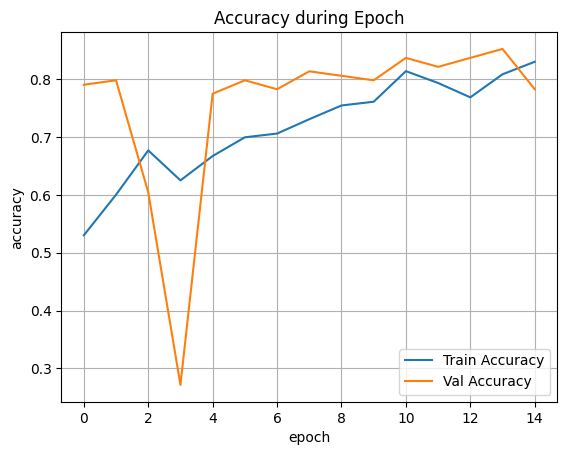

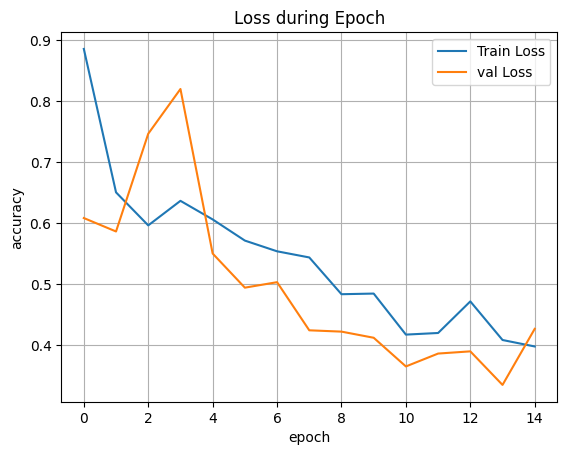

In [48]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Accuracy during Epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="val Loss")
plt.title("Loss during Epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.grid(True)
plt.show()

Evaluation

In [49]:
import numpy as np

def predict_image(img_path, img_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])):
  img = tf.keras.utils.load_img(img_path, color_mode='rgb', target_size=img_size)
  img_array = tf.keras.utils.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  prediction = model.predict(img_array)[0][0]
  pred_class = 1 if prediction >= 0.5 else 0
  label = class_names[pred_class]

  confidence = prediction if pred_class ==1 else (1-prediction)

  print(f"Prediction: {label} ({prediction:.2f}) | Confidence: {confidence*100:.2f}%")

  plt.imshow(img, cmap='gray')
  plt.title(f"Model Predict: {label}\nConfidence: ({confidence*100:.2f})%")
  plt.axis("off")
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction: Damaged (0.27) | Confidence: 72.85%


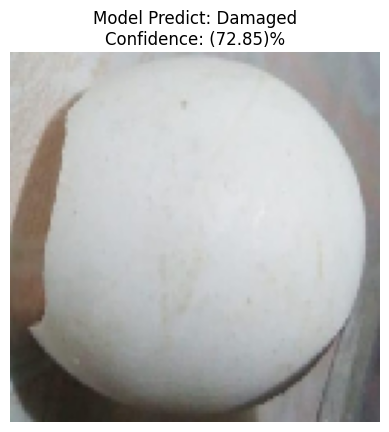

In [50]:
predict_image("/content/drive/MyDrive/Data/egg-split-cropped/test/Damaged/damaged_117_jpg.rf.06540fb72c08746ad745affdb31856b0_0.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction: Not Damaged (0.70) | Confidence: 70.26%


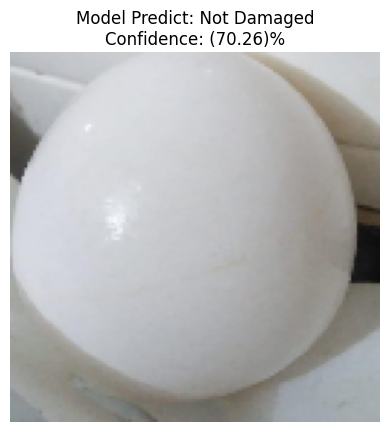

In [51]:
predict_image("/content/drive/MyDrive/Data/egg-split-cropped/test/Not Damaged/not_damaged_106_jpg.rf.149578a80387b115d313390fa8c9445d_0.jpg")